# Project
This is starter code designed to provide the basic instructions on how to use the dataset and models.
Feel free to create your code from scratch or modify this as you wish.

Submit a compressed archive containing all source code files.
Ensure the code is well-documented, with comments explaining key functions and logic.

## Project description

**Goal:** To be able to reconstruct the upper limbs poses (MoCap) based on inertial data (IMU)

**Motivation:** MoCap data collection is expensive and requires very controlled environments. On the other hand, IMU data collection is cheaper and portable. Reconstructing MoCap from IMU would offer a cheap alternative to predict upper-limb poses and improve downstream HAR tasks.

**Problem formulation:** To create a system that receives IMU data in form of local acceleration and gyroscope and predicts relative coordinates of shoulder, elbow, wrist and thumb with respect to the subject's center of gravity
- Let $a_l, a_r, \omega_l, \omega_r \in R^{T \times 3}$ be the arrays of local left/right acceleration and gyroscope
- Let $p_{ls}, p_{le}, p_{lw}, p_{lt}, p_{rs}, p_{re}, p_{rw}, p_{rt} \in R^{T \times 3}$ be the arrays of relative positions left/right of shoulder, elbow, wrist and thumb with respect to the anatomical frame of coordinates (see next section for more info)
- Develop a system $f(a_l, a_r, \omega_l, \omega_r) \rightarrow \hat p_{ls}, \hat p_{le}, \hat p_{lw}, \hat p_{lt}, \hat p_{rs}, \hat p_{re}, \hat p_{rw}, \hat p_{rt}$ such that $\hat p_i$ is a good estimator of $p_i$

**Considerations:**
- What is a good estimator? A typical approach is to say $\hat p_i$ is a good esimator of $p_i$ if $||\hat p_i - p_i||_2 \approx 0$. However, it is encouraged to explore additional ways to measure this, such as, preservation of bone lengths (i.e., $||\hat p_{ls}[t] - \hat p_{le}[t]||_2$ is relatively constant $\forall t$), feasibility of joint angles (i.e., $\textrm{angle} (\hat p_{ls}[t], \hat p_{le}[t], \hat p_{lw}[t]) < \pi$), etc. **Be creative with this part.**
- What model to use? This is **the core of the project**, so make sure to develop a strong (not necessarily complex) model. Its performance will highly depend on what you defined in the previous consideration.
- How to treat temporal dimension? In the example below, different activities have different lengths. Therefore, in order to train each batch pads the shorter sequences to the longest for that batch. Feel free to use other approaches if you wish.
- Is subject distinction important? **Yes**, the example below provides a split using LOSO without CV, but you should use LOSO-CV. You can also try LOAO-CV (leave one activity out with cross validation).
- Use different data? Feel free to use other data, as long as you have pairs of MoCap/IMU. The data provided comes from AMASS [1], a MoCap dataset, from which IMU was obtained synthetically using VirtualIMU [2].


[1] Mahmood, Naureen, et al. "AMASS: Archive of motion capture as surface shapes." *Proceedings of the IEEE/CVF international conference on computer vision.* 2019.

[2] Gavier, Ignacio, et al. "VirtualIMU: Generating Virtual Wearable Inertial Data from Video for Deep Learning Applications." *2023 IEEE 19th International Conference on Body Sensor Networks (BSN).* IEEE, 2023.

## Data description

**Location:** Data is located in folder `./data/`

**Name convention:** Each file has a name with the structure `[activity]_s[subject_id]_[length].npz`, where `activity` is the activity performed by a subject, `subject_id` is a number in `(1-10)`, and `length` is the length of the activity measured in frames

**Content:** Each file contains the following arrays
- `time` of shape `(length,)`: array containing time information
- `leftShoulderPosRel` of shape `(length, 3)`: XYZ array containing left shoulder position relative to the subject's center of gravity
- `rightShoulderPosRel` of shape `(length, 3)`: XYZ array containing right shoulder position relative to the subject's center of gravity
- `leftElbowPosRel` of shape `(length, 3)`: XYZ array containing left elbow position relative to the subject's center of gravity
- `rightElbowPosRel` of shape `(length, 3)`: XYZ array containing right elbow position relative to the subject's center of gravity
- `leftWristPosRel` of shape `(length, 3)`: XYZ array containing left wrist position relative to the subject's center of gravity
- `rightWristPosRel` of shape `(length, 3)`: XYZ array containing right wrist position relative to the subject's center of gravity
- `leftFingerPosRel` of shape `(length, 3)`: XYZ array containing left thumb position relative to the subject's center of gravity
- `rightFingerPosRel` of shape `(length, 3)`: XYZ array containing right thumb position relative to the subject's center of gravity
- `accelerationLeftLoc` of shape `(length, 3)`: XYZ array containing left forearm local acceleration 
- `accelerationRightLoc` of shape `(length, 3)`: XYZ array containing right forearm local acceleration 
- `gyroLeftLoc` of shape `(length, 3)`: XYZ array containing left forearm local gyroscope 
- `gyroRightLoc` of shape `(length, 3)`: XYZ array containing right forearm local gyroscope 

**Axes convention (MoCap):** The data files assume the following directions for MoCap
- X: lateral direction, left to right is positive
- Y: frontal direction, back to front is positive
- Z: vertical direction, down to up is positive

**Axes convention (IMU):** The data files assume the following directions for IMU
- X: forearm direction, elbow to wrist is positive
- Y: ulnar-radial direction, in left sensor radial to ulnar is positive, in right sensor ulnar to radial is positive
- Z: palmar-dorsal direction, palmar to dorsal is positive

## Load data

In [1]:
import os
import sys
import glob

from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm
from IPython.display import HTML

In [2]:
filenames = glob.glob('./data/*.npz')
assert len(filenames) > 0, 'No data files found in ./data/'

filename = filenames[0]
data = np.load(filename)
print('Data containing:')
[print(f'Array {f} of shape {data[f].shape}') for f in data.files];

Data containing:
Array time of shape (884,)
Array leftShoulderPosRel of shape (884, 3)
Array rightShoulderPosRel of shape (884, 3)
Array leftElbowPosRel of shape (884, 3)
Array rightElbowPosRel of shape (884, 3)
Array leftWristPosRel of shape (884, 3)
Array rightWristPosRel of shape (884, 3)
Array leftFingerPosRel of shape (884, 3)
Array rightFingerPosRel of shape (884, 3)
Array accelerationLeftLoc of shape (884, 3)
Array accelerationRightLoc of shape (884, 3)
Array gyroLeftLoc of shape (884, 3)
Array gyroRightLoc of shape (884, 3)


## Visualize data

#### Extract MoCap

In [3]:
def extractMoCap(data):
    time = data['time'] # (T,)
    torso = np.stack([np.zeros_like(data['leftShoulderPosRel']),
                      data['leftShoulderPosRel'],
                      data['rightShoulderPosRel'],
                      np.zeros_like(data['rightShoulderPosRel'])], axis=1) # (T, 4, 3)
    left_arm = np.stack([data['leftShoulderPosRel'],
                         data['leftElbowPosRel'],
                         data['leftWristPosRel'],
                         data['leftFingerPosRel']], axis=1) # (T, 4, 3)
    right_arm = np.stack([data['rightShoulderPosRel'],
                          data['rightElbowPosRel'],
                          data['rightWristPosRel'],
                          data['rightFingerPosRel']], axis=1) # (T, 4, 3)

    return time, torso, left_arm, right_arm

#### Visualize MoCap

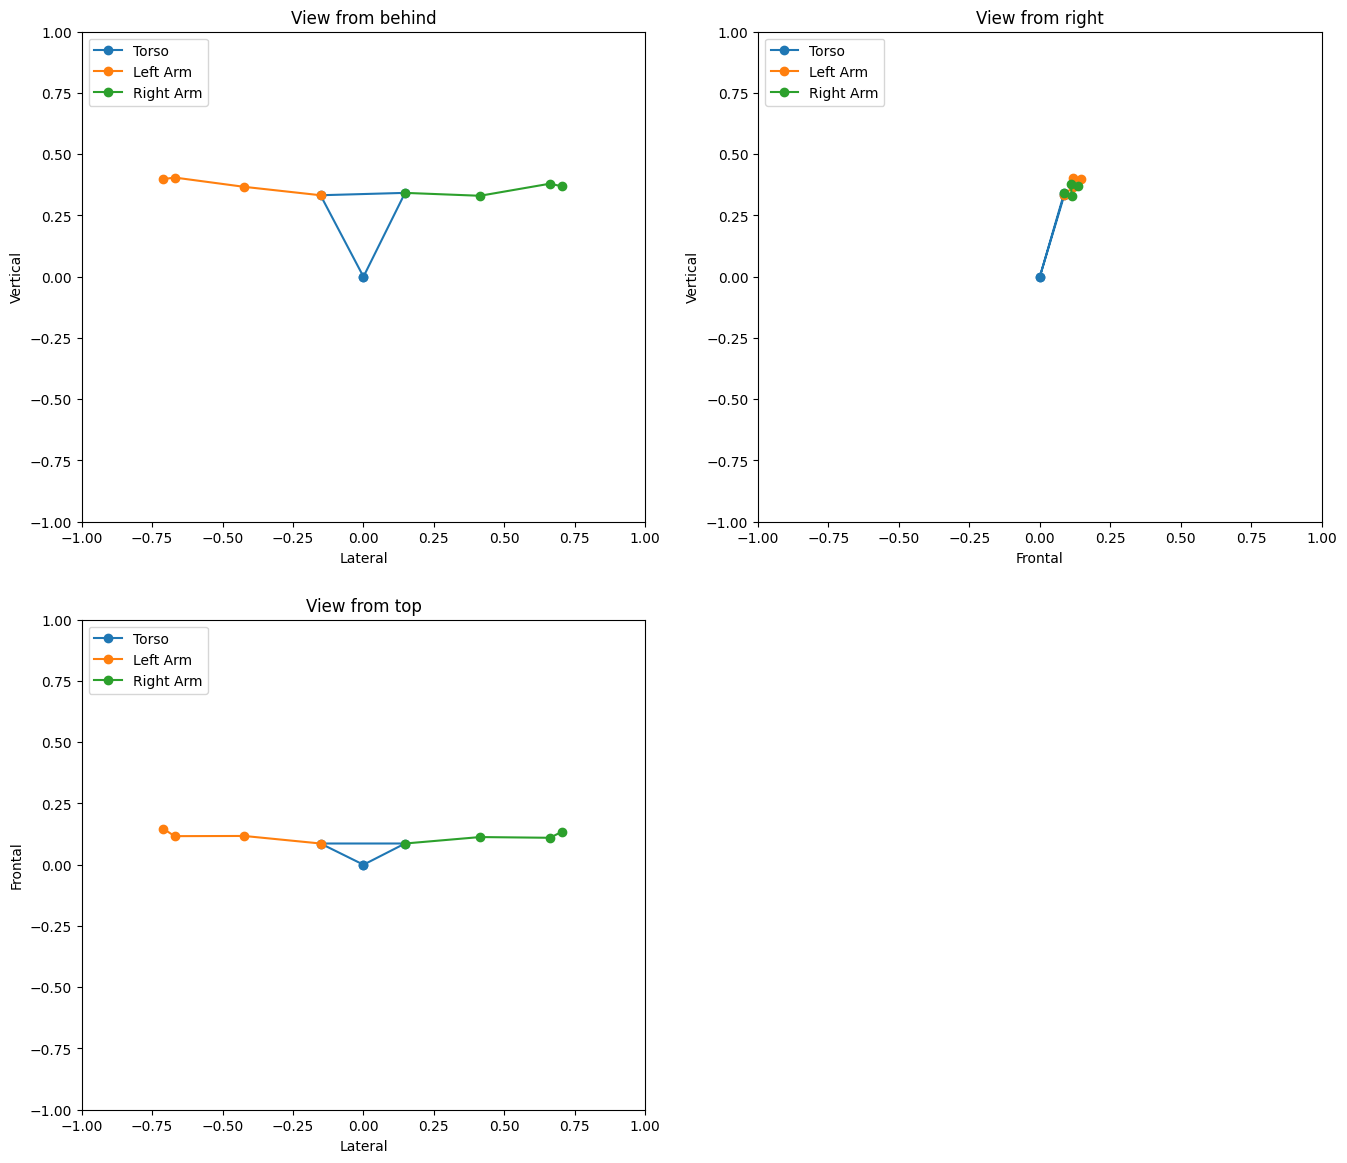

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(16,14))

t = 0 # Select frame to observe
time, torso, left_arm, right_arm = extractMoCap(data)

[ax[i,j].set_xlim(-1,1) for i in range(2) for j in range(2)]
[ax[i,j].set_ylim(-1,1) for i in range(2) for j in range(2)]

ax[0,0].set_title('View from behind')
ax[0,0].set_xlabel('Lateral')
ax[0,0].set_ylabel('Vertical')
t_00, = ax[0,0].plot(torso[t,:,0], torso[t,:,2], '-o', label='Torso')
l_00, = ax[0,0].plot(left_arm[t,:,0], left_arm[t,:,2], '-o', label='Left Arm')
r_00, = ax[0,0].plot(right_arm[t,:,0], right_arm[t,:,2], '-o', label='Right Arm')
ax[0,0].legend(loc='upper left')

ax[0,1].set_title('View from right')
ax[0,1].set_xlabel('Frontal')
ax[0,1].set_ylabel('Vertical')
t_01, = ax[0,1].plot(torso[t,:,1], torso[t,:,2], '-o', label='Torso')
l_01, = ax[0,1].plot(left_arm[t,:,1], left_arm[t,:,2], '-o', label='Left Arm')
r_01, = ax[0,1].plot(right_arm[t,:,1], right_arm[t,:,2], '-o', label='Right Arm')
ax[0,1].legend(loc='upper left')

ax[1,0].set_title('View from top')
ax[1,0].set_xlabel('Lateral')
ax[1,0].set_ylabel('Frontal')
t_10, = ax[1,0].plot(torso[t,:,0], torso[t,:,1], '-o', label='Torso')
l_10, = ax[1,0].plot(left_arm[t,:,0], left_arm[t,:,1], '-o', label='Left Arm')
r_10, = ax[1,0].plot(right_arm[t,:,0], right_arm[t,:,1], '-o', label='Right Arm')
ax[1,0].legend(loc='upper left')

ax[1,1].set_axis_off()

#### Extract IMU

In [5]:
def extractIMU(data):
    time = data['time'] # (T,)
    left_acc = data['accelerationLeftLoc'] # (T, 3)
    right_acc = data['accelerationRightLoc'] # (T, 3)
    left_gyro = data['gyroLeftLoc'] # (T, 3)
    right_gyro = data['gyroRightLoc'] # (T, 3)

    return time, left_acc, right_acc, left_gyro, right_gyro

#### Visualize IMU

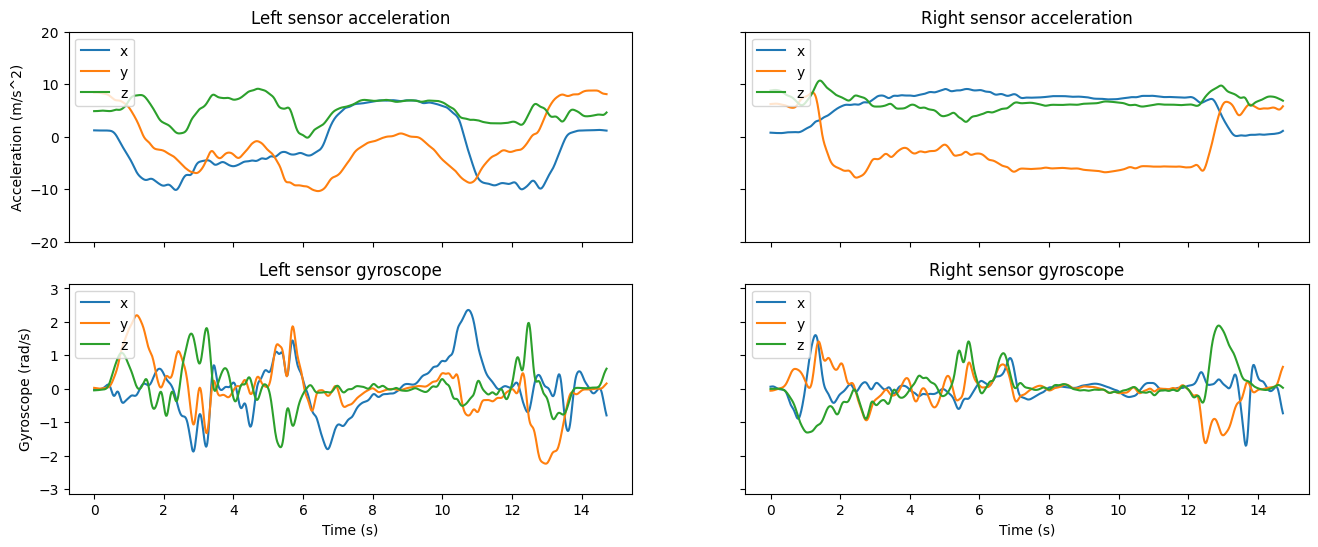

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(16,6), sharex=True, sharey='row')

time, left_acc, right_acc, left_gyro, right_gyro = extractIMU(data)

ax[0,0].set_ylim(-20,20)
ax[1,0].set_ylim(-np.pi,np.pi)

ax[0,0].set_title('Left sensor acceleration')
ax[0,0].set_ylabel('Acceleration (m/s^2)')
ax[0,0].plot(time, left_acc, label=['x', 'y', 'z'])
ax[0,0].legend(loc='upper left')

ax[0,1].set_title('Right sensor acceleration')
ax[0,1].plot(time, right_acc, label=['x', 'y', 'z'])
ax[0,1].legend(loc='upper left')

ax[1,0].set_title('Left sensor gyroscope')
ax[1,0].set_xlabel('Time (s)')
ax[1,0].set_ylabel('Gyroscope (rad/s)')
ax[1,0].plot(time, left_gyro, label=['x', 'y', 'z'])
ax[1,0].legend(loc='upper left')

ax[1,1].set_title('Right sensor gyroscope')
ax[1,1].set_xlabel('Time (s)')
ax[1,1].plot(time, right_gyro, label=['x', 'y', 'z'])
ax[1,1].legend(loc='upper left')

## Create PyTorch dataset

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import math
from preprocess import IMUPoseDataset

#### Create custom dataset class

In [8]:
class CustomDataset(Dataset):
    def __init__(self, filenames):
        self.filenames = filenames
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        data = np.load(filename)
        time, torso, left_arm, right_arm = extractMoCap(data)
        time, left_acc, right_acc, left_gyro, right_gyro = extractIMU(data)

        mocap = np.concatenate([left_arm, right_arm], axis=1) # (T, 8, 3)
        imu = np.stack([left_acc, right_acc, left_gyro, right_gyro], axis=1) # (T, 4, 3)

        return {'time': torch.tensor(time, dtype=torch.float32),
                'mocap': torch.tensor(mocap, dtype=torch.float32),
                'imu': torch.tensor(imu, dtype=torch.float32)}

#### Get subjects

In [9]:
subjects = np.unique([f.split('_')[-2] for f in filenames])

print(f'Found subjects: {subjects}')

Found subjects: ['s1' 's10' 's2' 's3' 's4' 's5' 's6' 's7' 's8' 's9']


#### Split train/test using LOSO

In [10]:
permutation = np.random.permutation(len(subjects))
train_subjects = subjects[permutation[:-1]]
test_subjects = subjects[permutation[-1:]]

print(f'Training on subjects: {train_subjects}')
print(f'Testing on subjects: {test_subjects}')

Training on subjects: ['s2' 's5' 's4' 's8' 's7' 's9' 's10' 's1' 's6']
Testing on subjects: ['s3']


#### Instantiate datasets

In [11]:
train_dataset = CustomDataset([f for f in filenames if any(s == f.split('_')[-2] for s in train_subjects)])
test_dataset = CustomDataset([f for f in filenames if any(s == f.split('_')[-2] for s in test_subjects)])

#### Collate function to deal with different lengths

In [12]:
def collate_fn(batch):
    longest_sample = max(batch, key=lambda x: len(x['time']))
    max_len = len(longest_sample['time']) # max_len
    padded_batch = []

    for sample in batch:
        padding_len = max_len - len(sample['time'])
        padded_sample = {}
        padded_sample['mocap'] = torch.cat([sample['mocap'],
                                            sample['mocap'][-1:].repeat(padding_len,1,1)]) # (max_len, 8, 3)
        acc = torch.cat([sample['imu'][:,[0,1]],
                         sample['imu'][-1:,[0,1]].repeat(padding_len,1,1)]) # (max_len, 2, 3)
        gyro = torch.cat([sample['imu'][:,[2,3]],
                          torch.zeros_like(sample['imu'][-1:,[2,3]]).repeat(padding_len,1,1)]) # (max_len, 2, 3)
        padded_sample['imu'] = torch.cat([acc, gyro], dim=1) # (max_len, 4, 3)
        padded_batch.append(padded_sample)

    return {'time': longest_sample['time'],
            'mocap': torch.stack([sample['mocap'] for sample in padded_batch]),
            'imu': torch.stack([sample['imu'] for sample in padded_batch])}

#### Instantiate dataloaders

In [13]:
# batch_size = 10

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [14]:
root_dir = 'data/'
win_len, step = 100, 25
batch_size    = 64

ds = IMUPoseDataset(root_dir, win_len, step)
test_subj = 1
train_ids = [i for i, sid in enumerate(ds.subj_ids) if sid != test_subj]
test_ids  = [i for i, sid in enumerate(ds.subj_ids) if sid == test_subj]

def collate(batch):
    imu   = torch.stack([b[0] for b in batch])    # (B, T, 12)
    mocap = torch.stack([b[1] for b in batch])    # (B, T, J, 3)
    return {'imu': imu, 'mocap': mocap}

train_loader = DataLoader(Subset(ds, train_ids),
                          batch_size=batch_size,
                          shuffle=True, drop_last=True,
                          collate_fn=collate)
test_loader  = DataLoader(Subset(ds, test_ids),
                          batch_size=batch_size,
                          shuffle=False,
                          collate_fn=collate)

## Train model

#### Define architecture

In [15]:
### LSTM
class SimpleNN(nn.Module):
    def __init__(self, input_size=4*3, hidden_size=8*3, num_layers=2):
        super(SimpleNN, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

    def forward(self, x):
        x = x.flatten(2) # (N, T, 12)
        out, _ = self.lstm(x) # (N, T, 24)
        return out
    

### Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x : (B, T, D)
        """
        T = x.size(1)
        return x + self.pe[:T]

class IMU2PoseTransformer(nn.Module):
    def __init__(self,
                 d_in = 4*3,      # IMU channels
                 d_model = 96,
                 nhead = 4,
                 num_layers = 3,
                 dim_feedforward = 256,
                 dropout = 0.1,
                 out_dim = 8*3,
                 J = 8):
        super().__init__()
        self.input_proj = nn.Linear(d_in, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model,
                                                   nhead,
                                                   dim_feedforward,
                                                   dropout,
                                                   batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.posenc = PositionalEncoding(d_model)
        self.head = nn.Linear(d_model, out_dim)
        self.J = J

    def forward(self, x):
        """
        x : (B, T, 12)
        returns (B, T, 24)
        """
        h = self.input_proj(x)
        h = self.posenc(h)
        h = self.encoder(h)
        out = self.head(h)
        B,T,_ = out.shape
        return out.view(B, T, self.J, 3)

#### Instantiate model

In [16]:
# model = SimpleNN(input_size=4*3, hidden_size=8*3, num_layers=2)
model = IMU2PoseTransformer(d_in=12, d_model=96, nhead=4, num_layers=3, J=8)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

#### Define criterion

In [17]:
criterion = nn.MSELoss()

#### Initialize optimizer

In [18]:
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#### Run epochs

In [19]:
# num_epochs = 2

# for epoch in range(num_epochs):
#     print(f'Running epoch [{epoch+1}/{num_epochs}]')

#     for i, batch in enumerate(train_dataloader):
#         # Forward pass
#         outputs = model(batch['imu'])
#         loss = criterion(outputs.view(*batch['mocap'].shape), batch['mocap'])

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if (i+1) % 10 == 0:
#             print(f'Train Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')
    
#     for i, batch in enumerate(test_dataloader):
#         # Forward pass
#         outputs = model(batch['imu'])
#         loss = criterion(outputs.view(*batch['mocap'].shape), batch['mocap'])

#         if (i+1) % 10 == 0:
#             print(f'Test Step [{i+1}/{len(test_dataloader)}], Loss: {loss.item():.4f}')

In [20]:
num_epochs = 5
for epoch in range(num_epochs):
    print(f"\nRunning epoch [{epoch+1}/{num_epochs}]")

    # ---------- training ----------
    model.train()
    for i, batch in enumerate(train_loader):
        outputs = model(batch['imu'].to(device))
        loss    = criterion(outputs, batch['mocap'].to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Train Step [{i+1}/{len(train_loader)}], "
                  f"Loss: {loss.item():.4f}")

    # ---------- testing ----------
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            outputs = model(batch['imu'].to(device))
            loss    = criterion(outputs, batch['mocap'].to(device))

            if (i + 1) % 100 == 0:
                print(f"Test  Step [{i+1}/{len(test_loader)}], "
                      f"Loss: {loss.item():.4f}")


Running epoch [1/5]
Train Step [100/785], Loss: 0.0219
Train Step [200/785], Loss: 0.0182
Train Step [300/785], Loss: 0.0096
Train Step [400/785], Loss: 0.0109
Train Step [500/785], Loss: 0.0084
Train Step [600/785], Loss: 0.0086
Train Step [700/785], Loss: 0.0100
Test  Step [100/183], Loss: 0.0105

Running epoch [2/5]
Train Step [100/785], Loss: 0.0109
Train Step [200/785], Loss: 0.0088
Train Step [300/785], Loss: 0.0075
Train Step [400/785], Loss: 0.0070
Train Step [500/785], Loss: 0.0102
Train Step [600/785], Loss: 0.0067
Train Step [700/785], Loss: 0.0070
Test  Step [100/183], Loss: 0.0083

Running epoch [3/5]
Train Step [100/785], Loss: 0.0056
Train Step [200/785], Loss: 0.0059
Train Step [300/785], Loss: 0.0058
Train Step [400/785], Loss: 0.0064
Train Step [500/785], Loss: 0.0053
Train Step [600/785], Loss: 0.0056
Train Step [700/785], Loss: 0.0062
Test  Step [100/183], Loss: 0.0072

Running epoch [4/5]
Train Step [100/785], Loss: 0.0047
Train Step [200/785], Loss: 0.0067
Train 